# facebookarchive/caffe2 归档项目分析

In [1]:
var openDigger = require('../src/open_digger');
var query = openDigger.driver.clickhouse.query;
query(    `SHOW TABLES from github_log`
     ).then(res=>{    
    console.log(res);
})

[
  { name: 'year2015' },
  { name: 'year2016' },
  { name: 'year2017' },
  { name: 'year2018' },
  { name: 'year2019' },
  { name: 'year2020' },
  { name: 'year2021' },
  { name: 'year2022' }
]


In [2]:
var id = 38066334;
//38066334 facebookarchive/caffe2 2015-2018 于2018年归档
var years = [ 2015, 2016, 2017, 2018 ]

In [3]:
var year = 2019;
var limit = 1;

query(    
`SELECT   repo_name
FROM github_log.year${year}    
WHERE repo_id=${id}
LIMIT ${limit}`).then(res=>{    
    console.log(res);
});

[ { repo_name: 'facebookarchive/caffe2' } ]


## 1 每月新增 Star 和 Fork 的个数

### star

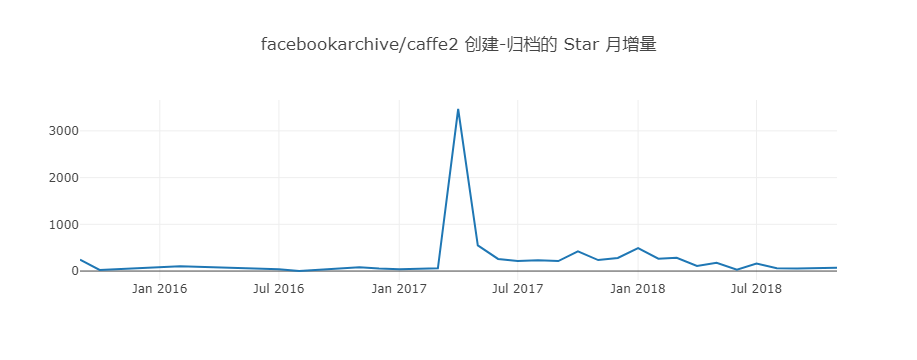

┌─────────┬───────────┬─────────────┐
│ (index) │   月份    │ Star 月增量 │
├─────────┼───────────┼─────────────┤
│    0    │ '2015-9'  │     243     │
│    1    │ '2015-10' │     24      │
│    2    │ '2016-2'  │     101     │
│    3    │ '2016-6'  │     43      │
│    4    │ '2016-7'  │     40      │
│    5    │ '2016-8'  │      1      │
│    6    │ '2016-10' │     56      │
│    7    │ '2016-11' │     83      │
│    8    │ '2016-12' │     56      │
│    9    │ '2017-1'  │     38      │
│   10    │ '2017-2'  │     49      │
│   11    │ '2017-3'  │     58      │
│   12    │ '2017-4'  │    3468     │
│   13    │ '2017-5'  │     549     │
│   14    │ '2017-6'  │     259     │
│   15    │ '2017-7'  │     213     │
│   16    │ '2017-8'  │     233     │
│   17    │ '2017-9'  │     214     │
│   18    │ '2017-10' │     423     │
│   19    │ '2017-11' │     235     │
│   20    │ '2017-12' │     280     │
│   21    │ '2018-1'  │     491     │
│   22    │ '2018-2'  │     263     │
│   23    │ '2018

In [4]:
Promise.all(years.map(y => {
    var q = 
    `select id, toYear(created_date) as year, toMonth(created_date) as month, repo_stargazers_count
     from github_log.year${y}
     where id in
        (
        select max(id)
         from
            (select id, toMonth(created_date) as created_month
             from github_log.year${y}
             where repo_id=${id}
                and type in ('PullRequestEvent','PullRequestReviewCommentEvent'))
         group by created_month
         )
    order by(created_date)`
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    var year = [], month = [], starNum = [], starInc = [];
    
    data.forEach(d => {
        year = year.concat(d.map(t => t.year));
        month = month.concat(d.map(t => t.month));
        starNum = starNum.concat(d.map(t => t.repo_stargazers_count));
    })

    var xAxis = [];
    var tableList = [];

    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString());
        if(i) {
            starInc.push(starNum[i] - starNum[i-1]);        
        } else {
            starInc.push(starNum[i]);        
        }
        tableList.push([xAxis[i], starInc[i]])

    }
    openDigger.render.plotly([
        {x: xAxis, y: starInc, mode: 'scatter', name: 'Star 月增量'}
    ], {
        title: 'facebookarchive/caffe2 创建-归档的 Star 月增量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '月份': l[0],
            'Star 月增量': l[1]
        };
    
    }));
});


### Fork

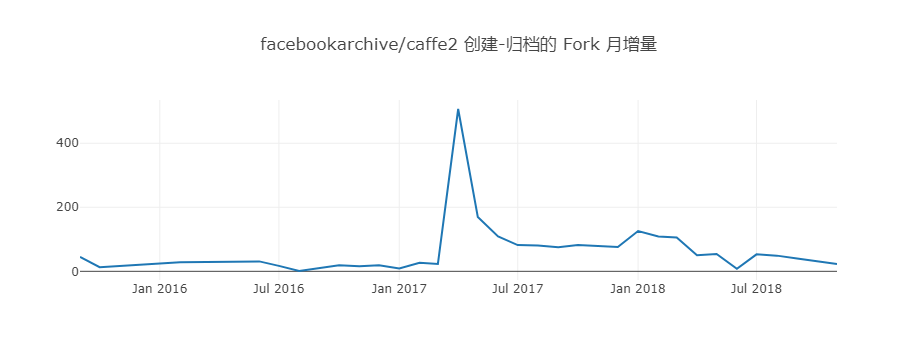

┌─────────┬───────────┬─────────────┐
│ (index) │   月份    │ Fork 月增量 │
├─────────┼───────────┼─────────────┤
│    0    │ '2015-9'  │     45      │
│    1    │ '2015-10' │     13      │
│    2    │ '2016-2'  │     28      │
│    3    │ '2016-6'  │     31      │
│    4    │ '2016-7'  │     17      │
│    5    │ '2016-8'  │      1      │
│    6    │ '2016-10' │     19      │
│    7    │ '2016-11' │     16      │
│    8    │ '2016-12' │     19      │
│    9    │ '2017-1'  │      9      │
│   10    │ '2017-2'  │     27      │
│   11    │ '2017-3'  │     23      │
│   12    │ '2017-4'  │     507     │
│   13    │ '2017-5'  │     170     │
│   14    │ '2017-6'  │     109     │
│   15    │ '2017-7'  │     82      │
│   16    │ '2017-8'  │     81      │
│   17    │ '2017-9'  │     75      │
│   18    │ '2017-10' │     82      │
│   19    │ '2017-11' │     80      │
│   20    │ '2017-12' │     76      │
│   21    │ '2018-1'  │     126     │
│   22    │ '2018-2'  │     109     │
│   23    │ '2018

In [5]:
Promise.all(years.map(y => {
    var q = 
    `select toYear(created_date) as year, toMonth(created_date) as month, repo_forks_count
     from github_log.year${y}
     where id in
        (select max(id)
         from
            (select id, toMonth(created_date) as created_month
             from github_log.year${y}
             where repo_id=${id}
                and type in ('PullRequestEvent','PullRequestReviewCommentEvent'))
         group by (created_month))
    order by(created_date)`
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    var year = [], month = [], forkNum = [], forkInc = [];
    
    data.forEach(d => {
        year = year.concat(d.map(t => t.year));
        month = month.concat(d.map(t => t.month));
        forkNum = forkNum.concat(d.map(t => t.repo_forks_count));
    })

    var xAxis = [];
    var tableList = [];

    for(var i=0; i<year.length; i++){
        xAxis.push(year[i]+'-'+month[i].toString());
        if(i) {
            forkInc.push(forkNum[i] - forkNum[i-1]);        
        } else {
            forkInc.push(forkNum[i]);        
        }
        tableList.push([xAxis[i], forkInc[i]])

    }
    openDigger.render.plotly([
        {x: xAxis, y: forkInc, mode: 'scatter', name: 'Fork 月增量'}
    ], {
        title: 'facebookarchive/caffe2 创建-归档的 Fork 月增量',
        xais: {type: 'category'}
    });
    console.table(tableList.map((l, i) => {
        return {
            '月份': l[0],
            'Fork 月增量': l[1]
        };
    
    }));
});

## 2 每月打开 Issue 和 关闭 Issue 的个数

### 打开 issue

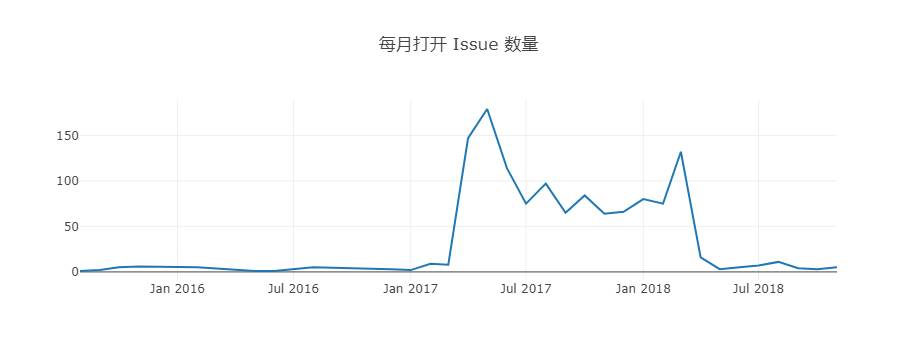

┌─────────┬───────────┬───────┐
│ (index) │     0     │   1   │
├─────────┼───────────┼───────┤
│    0    │ '2015-08' │  '1'  │
│    1    │ '2015-09' │  '2'  │
│    2    │ '2015-10' │  '5'  │
│    3    │ '2015-11' │  '6'  │
│    4    │ '2016-02' │  '5'  │
│    5    │ '2016-05' │  '1'  │
│    6    │ '2016-06' │  '1'  │
│    7    │ '2016-08' │  '5'  │
│    8    │ '2016-12' │  '3'  │
│    9    │ '2017-01' │  '2'  │
│   10    │ '2017-02' │  '9'  │
│   11    │ '2017-03' │  '8'  │
│   12    │ '2017-04' │ '147' │
│   13    │ '2017-05' │ '179' │
│   14    │ '2017-06' │ '114' │
│   15    │ '2017-07' │ '75'  │
│   16    │ '2017-08' │ '97'  │
│   17    │ '2017-09' │ '65'  │
│   18    │ '2017-10' │ '84'  │
│   19    │ '2017-11' │ '64'  │
│   20    │ '2017-12' │ '66'  │
│   21    │ '2018-01' │ '80'  │
│   22    │ '2018-02' │ '75'  │
│   23    │ '2018-03' │ '132' │
│   24    │ '2018-04' │ '16'  │
│   25    │ '2018-05' │  '3'  │
│   26    │ '2018-06' │  '5'  │
│   27    │ '2018-07' │  '7'  │
│   28  

In [6]:
Promise.all(years.map(y=>{
    var q=`
    select toYear(issue_created_at) as issue_create_year, toMonth(issue_created_at)as issue_create_month,
        count(issue_number) as create_issue_number
    from github_log.year${y}
    where repo_id=${id}
        and type = 'IssuesEvent'
        and action = 'opened'
    group by (issue_create_year, issue_create_month)
    order by (issue_create_year, issue_create_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var createIssueCount = [], months = [], issuetable =[];
        data.forEach(d=> {
        d.forEach(t => {
            createIssueCount.push(t.create_issue_number);
            months.push(t.issue_create_year + '-' + t.issue_create_month.toString().padStart(2, '0'));
            issuetable.push([t.issue_create_year + '-' + t.issue_create_month.toString().padStart(2, '0'),t.create_issue_number])
    });
        });
        openDigger.render.plotly([
        {x: months, y: createIssueCount, mode: 'scatter', name: '每月打开 Issue 数量'},
    ], {
        title: '每月打开 Issue 数量'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
         console.table(issuetable);
});

### 关闭 issue

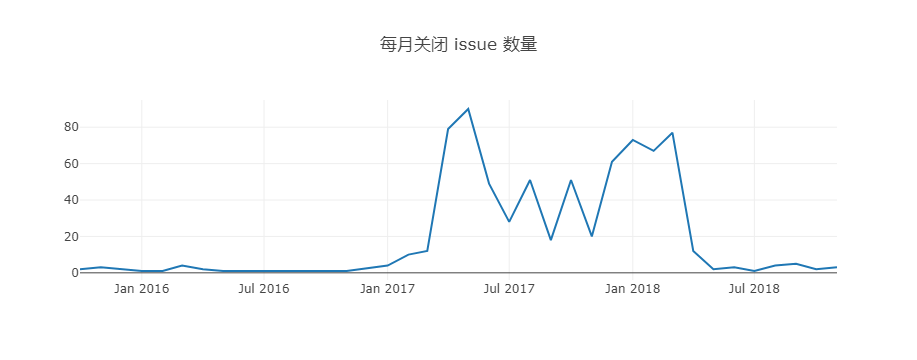

┌─────────┬───────────┬──────┐
│ (index) │     0     │  1   │
├─────────┼───────────┼──────┤
│    0    │ '2015-10' │ '2'  │
│    1    │ '2015-11' │ '3'  │
│    2    │ '2016-01' │ '1'  │
│    3    │ '2016-02' │ '1'  │
│    4    │ '2016-03' │ '4'  │
│    5    │ '2016-04' │ '2'  │
│    6    │ '2016-05' │ '1'  │
│    7    │ '2016-09' │ '1'  │
│    8    │ '2016-11' │ '1'  │
│    9    │ '2017-01' │ '4'  │
│   10    │ '2017-02' │ '10' │
│   11    │ '2017-03' │ '12' │
│   12    │ '2017-04' │ '79' │
│   13    │ '2017-05' │ '90' │
│   14    │ '2017-06' │ '49' │
│   15    │ '2017-07' │ '28' │
│   16    │ '2017-08' │ '51' │
│   17    │ '2017-09' │ '18' │
│   18    │ '2017-10' │ '51' │
│   19    │ '2017-11' │ '20' │
│   20    │ '2017-12' │ '61' │
│   21    │ '2018-01' │ '73' │
│   22    │ '2018-02' │ '67' │
│   23    │ '2018-03' │ '77' │
│   24    │ '2018-04' │ '12' │
│   25    │ '2018-05' │ '2'  │
│   26    │ '2018-06' │ '3'  │
│   27    │ '2018-07' │ '1'  │
│   28    │ '2018-08' │ '4'  │
│   29  

In [7]:
Promise.all(years.map(y=>{
    var q=`
    select toYear(issue_closed_at) as issue_close_year, toMonth(issue_closed_at)as issue_close_month,
        count(issue_number) as close_issue_number
    from github_log.year${y}
    where repo_id=${id}
        and type = 'IssuesEvent'
        and action = 'closed'
    group by (issue_close_year, issue_close_month)
    order by (issue_close_year, issue_close_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var closeIssueCount = [], months = [], issuetable =[];
        data.forEach(d=> {
        d.forEach(t => {
            closeIssueCount.push(t.close_issue_number);
            months.push(t.issue_close_year + '-' + t.issue_close_month.toString().padStart(2, '0'));
            issuetable.push([t.issue_close_year + '-' + t.issue_close_month.toString().padStart(2, '0'),t.close_issue_number])
    });
        });
        openDigger.render.plotly([
        {x: months, y: closeIssueCount, mode: 'scatter', name: '每月关闭 issue 数量'},
    ], {
        title: '每月关闭 issue 数量'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
         console.table(issuetable);
});

## 3 每月打开 PR 和 合入 PR 的个数

### 打开 PR

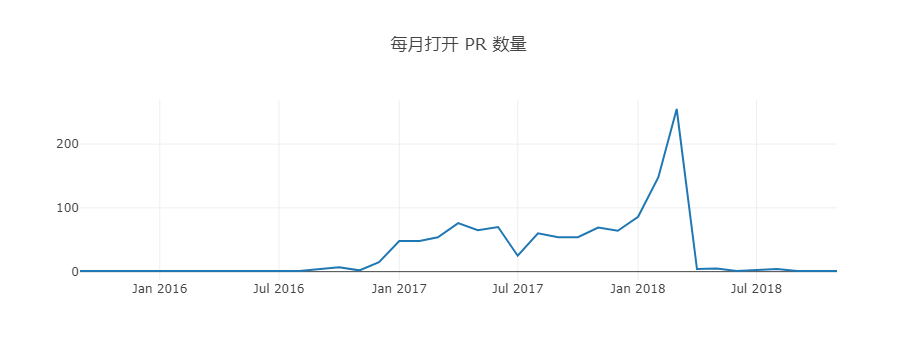

┌─────────┬───────────┬───────┐
│ (index) │     0     │   1   │
├─────────┼───────────┼───────┤
│    0    │ '2015-09' │  '1'  │
│    1    │ '2015-10' │  '1'  │
│    2    │ '2016-02' │  '1'  │
│    3    │ '2016-06' │  '1'  │
│    4    │ '2016-07' │  '2'  │
│    5    │ '2016-08' │  '1'  │
│    6    │ '2016-10' │  '7'  │
│    7    │ '2016-11' │  '2'  │
│    8    │ '2016-12' │ '15'  │
│    9    │ '2017-01' │ '48'  │
│   10    │ '2017-02' │ '48'  │
│   11    │ '2017-03' │ '54'  │
│   12    │ '2017-04' │ '76'  │
│   13    │ '2017-05' │ '65'  │
│   14    │ '2017-06' │ '70'  │
│   15    │ '2017-07' │ '25'  │
│   16    │ '2017-08' │ '60'  │
│   17    │ '2017-09' │ '54'  │
│   18    │ '2017-10' │ '54'  │
│   19    │ '2017-11' │ '69'  │
│   20    │ '2017-12' │ '64'  │
│   21    │ '2018-01' │ '86'  │
│   22    │ '2018-02' │ '148' │
│   23    │ '2018-03' │ '255' │
│   24    │ '2018-04' │  '4'  │
│   25    │ '2018-05' │  '5'  │
│   26    │ '2018-06' │  '1'  │
│   27    │ '2018-08' │  '4'  │
│   28  

In [8]:
Promise.all(years.map(y=>{
    var q=`
    select toYear(created_at) as pr_open_year, toMonth(created_at)as pr_open_month, count(*) as pr_open_number
    from github_log.year${y}
    where repo_id=${id}
        and type = 'PullRequestEvent'
        and action = 'opened'
    group by (pr_open_year, pr_open_month)
    order by (pr_open_year, pr_open_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var openPRCount = [], months = [], prtable =[];
        data.forEach(d=> {
        d.forEach(t => {
            openPRCount.push(t.pr_open_number);
            months.push(t.pr_open_year + '-' + t.pr_open_month.toString().padStart(2, '0'));
            prtable.push([t.pr_open_year + '-' + t.pr_open_month.toString().padStart(2, '0'),t.pr_open_number])
    });
        });
        openDigger.render.plotly([
        {x: months, y: openPRCount, mode: 'scatter', name: '每月打开 PR 数量'},
    ], {
        title: '每月打开 PR 数量'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
         console.table(prtable);
});

### 合入 PR

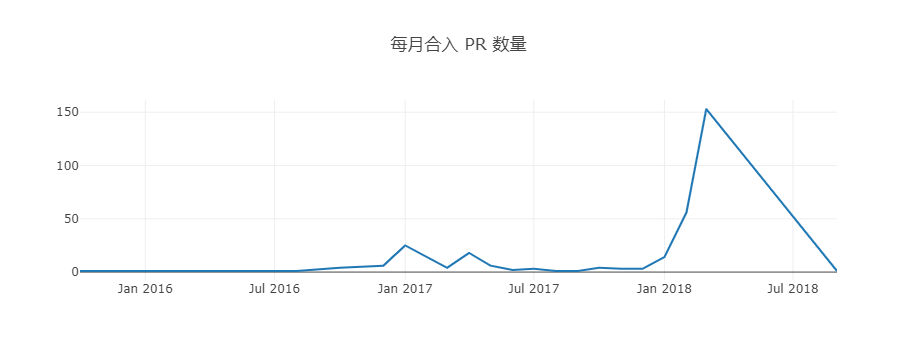

┌─────────┬───────────┬───────┐
│ (index) │     0     │   1   │
├─────────┼───────────┼───────┤
│    0    │ '2015-10' │  '1'  │
│    1    │ '2016-06' │  '1'  │
│    2    │ '2016-07' │  '1'  │
│    3    │ '2016-08' │  '1'  │
│    4    │ '2016-10' │  '4'  │
│    5    │ '2016-12' │  '6'  │
│    6    │ '2017-01' │ '25'  │
│    7    │ '2017-02' │ '14'  │
│    8    │ '2017-03' │  '4'  │
│    9    │ '2017-04' │ '18'  │
│   10    │ '2017-05' │  '6'  │
│   11    │ '2017-06' │  '2'  │
│   12    │ '2017-07' │  '3'  │
│   13    │ '2017-08' │  '1'  │
│   14    │ '2017-09' │  '1'  │
│   15    │ '2017-10' │  '4'  │
│   16    │ '2017-11' │  '3'  │
│   17    │ '2017-12' │  '3'  │
│   18    │ '2018-01' │ '14'  │
│   19    │ '2018-02' │ '56'  │
│   20    │ '2018-03' │ '153' │
│   21    │ '2018-09' │  '1'  │
└─────────┴───────────┴───────┘


In [9]:
Promise.all(years.map(y=>{
    var q=`
    select toYear(pull_merged_at) as pr_merge_year, toMonth(pull_merged_at)as pr_merge_month, count(*) as pr_merge_number
    from github_log.year${y}
    where repo_id=${id}
        and type = 'PullRequestEvent'
        and action = 'closed'
        and pull_merged = 1
    group by (pr_merge_year, pr_merge_month)
    order by (pr_merge_year, pr_merge_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var mergePRCount = [], months = [], prtable =[];
        data.forEach(d=> {
        d.forEach(t => {
            mergePRCount.push(t.pr_merge_number);
            months.push(t.pr_merge_year + '-' + t.pr_merge_month.toString().padStart(2, '0'));
            prtable.push([t.pr_merge_year + '-' + t.pr_merge_month.toString().padStart(2, '0'),t.pr_merge_number])
    });
        });
        openDigger.render.plotly([
        {x: months, y: mergePRCount, mode: 'scatter', name: '每月合入 PR 数量'},
    ], {
        title: '每月合入 PR 数量'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
         console.table(prtable);
});

## 4 每月在仓库中活跃的不同开发者总数

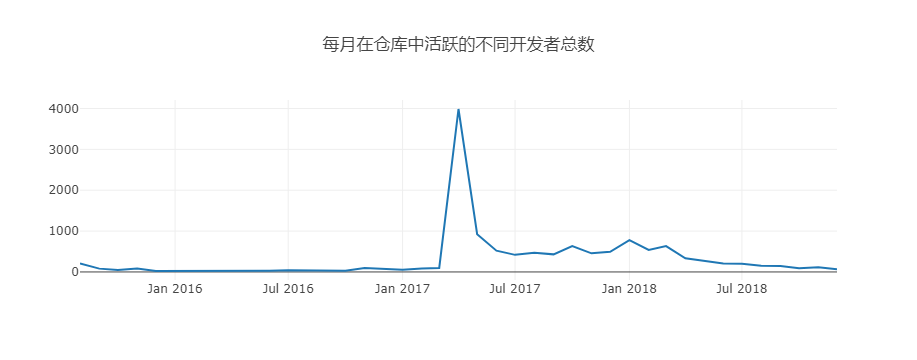

┌─────────┬───────────┬────────┐
│ (index) │     0     │   1    │
├─────────┼───────────┼────────┤
│    0    │ '2015-08' │ '206'  │
│    1    │ '2015-09' │  '81'  │
│    2    │ '2015-10' │  '45'  │
│    3    │ '2015-11' │  '83'  │
│    4    │ '2015-12' │  '24'  │
│    5    │ '2016-01' │  '23'  │
│    6    │ '2016-02' │  '26'  │
│    7    │ '2016-03' │  '27'  │
│    8    │ '2016-04' │  '27'  │
│    9    │ '2016-05' │  '23'  │
│   10    │ '2016-06' │  '30'  │
│   11    │ '2016-07' │  '40'  │
│   12    │ '2016-08' │  '32'  │
│   13    │ '2016-09' │  '32'  │
│   14    │ '2016-10' │  '30'  │
│   15    │ '2016-11' │  '97'  │
│   16    │ '2016-12' │  '82'  │
│   17    │ '2017-01' │  '53'  │
│   18    │ '2017-02' │  '83'  │
│   19    │ '2017-03' │  '97'  │
│   20    │ '2017-04' │ '3988' │
│   21    │ '2017-05' │ '922'  │
│   22    │ '2017-06' │ '520'  │
│   23    │ '2017-07' │ '418'  │
│   24    │ '2017-08' │ '467'  │
│   25    │ '2017-09' │ '430'  │
│   26    │ '2017-10' │ '634'  │
│   27    

In [10]:
Promise.all(years.map(y=>{
    var q=`
    select toYear(created_at) as act_year, toMonth(created_at) as act_month, count(distinct actor_id) as act_num 
    from github_log.year${y}
    where repo_id=${id}
    group by (act_year, act_month)
    order by (act_year, act_month)`;
    return openDigger.driver.clickhouse.query(q);
})).then(data =>
        {var actCount = [], months = [], acttable =[];
        data.forEach(d=> {
        d.forEach(t => {
            actCount.push(t.act_num);
            months.push(t.act_year + '-' + t.act_month.toString().padStart(2, '0'));
            acttable.push([t.act_year + '-' + t.act_month.toString().padStart(2, '0'), t.act_num])
    });
        });
        openDigger.render.plotly([
        {x: months, y: actCount, mode: 'scatter', name: '每月在仓库中活跃的不同开发者总数'},
    ], {
        title: '每月在仓库中活跃的不同开发者总数'
        ,yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' }
    });
         console.table(acttable);
});

## 5 Issue 从打开到关闭的平均时长和中位数（单位：天）

In [11]:
openDigger.driver.clickhouse.query(
    `select avg(issue_days) as issue_avg, median(issue_days) as issue_mid
    from(
    select dateDiff('day', issue_created_at, issue_closed_at) as issue_days 
    from github_log.year2015 
    where repo_id = ${id}
        and type= 'IssuesEvent' 
        and issue_days >= 0
        and action = 'closed'
    union all
    select dateDiff('day', issue_created_at, issue_closed_at) as issue_days 
    from github_log.year2016 
    where repo_id = ${id}
        and type= 'IssuesEvent' 
        and issue_days >= 0
        and action = 'closed'
    union all
    select dateDiff('day', issue_created_at, issue_closed_at) as issue_days 
    from github_log.year2017 
    where repo_id = ${id}
        and type= 'IssuesEvent' 
        and issue_days >= 0
        and action = 'closed'
    union all
    select dateDiff('day', issue_created_at, issue_closed_at) as issue_days 
    from github_log.year2018 
    where repo_id = ${id}
        and type= 'IssuesEvent' 
        and issue_days >= 0
        and action = 'closed'
    )`
).then(res=>{    console.log(res);});

[ { issue_avg: 34.53658536585366, issue_mid: 4 } ]


## 6 PR 从打开到合入的平均时长和中位数（单位：天）

In [12]:
openDigger.driver.clickhouse.query(`
select avg(dateDiff('day', open_time, close_time)) as pr_avg ,median(dateDiff('day', open_time, close_time)) as pr_mid from
(select issue_id, created_at as open_time
    from (select * from github_log.year2015 
        union all select * from github_log.year2016 
        union all select * from github_log.year2017
        union all select * from github_log.year2018) 
    where type='PullRequestEvent' 
        and action='opened' and 
        repo_id=${id})open_tb 
inner join 
(select issue_id, pull_merged_at as close_time
    from (select * from github_log.year2015 
        union all select * from github_log.year2016 
        union all select * from github_log.year2017 
        union all select * from github_log.year2018) 
    where type='PullRequestEvent' 
        and action='closed' 
        and repo_id=${id} 
        and pull_merged=1)merge_tb
on open_tb.issue_id=merge_tb.issue_id
`).then(res=>{    console.log(res);});

[ { pr_avg: 1.8095238095238095, pr_mid: 0 } ]


## 7 Issue 和 PR 从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

### Issue

In [13]:
openDigger.driver.clickhouse.query(`
select avg(dateDiff('day', open_time, response_time)) as issue_time_avg, 
        median(dateDiff('day', open_time, response_time)) as issue_time_mid 
from
(select issue_id, created_at as open_time
    from (select * from github_log.year2015 
        union all select * from github_log.year2016 
        union all select * from github_log.year2017 
        union all select * from github_log.year2018) 
    where type='IssuesEvent' 
    and action='opened' 
    and repo_id=${id})open_table 
inner join
(select issue_id, created_at as response_time
    from (select * from github_log.year2015 
        union all select * from github_log.year2016 
        union all select * from github_log.year2017 
        union all select * from github_log.year2018)x 
    where x.type='IssueCommentEvent' 
    and x.repo_id=${id}
    and x.issue_comments = '0'
    and x.issue_author_id <> x.issue_comment_author_id
    )response_table
on open_table.issue_id=response_table.issue_id
`).then(res=>{    console.log(res);});

[ { issue_time_avg: 15.79639175257732, issue_time_mid: 1 } ]


### PR

In [14]:
openDigger.driver.clickhouse.query(`
select avg(dateDiff('day', open_time, response_time)) as pr_time_avg, 
        median(dateDiff('day', open_time, response_time)) as pr_time_mid
from
(select issue_id, created_at as open_time
from (
    select * from github_log.year2015
        union all select * from github_log.year2016 
        union all select * from github_log.year2017 
        union all select * from github_log.year2018) 
    where type='PullRequestEvent' 
        and action='opened' 
        and repo_id=${id}
        )open_table 
inner join
(select issue_id, created_at as response_time
from (
    select * from github_log.year2015 
        union all select * from github_log.year2016 
        union all select * from github_log.year2017 
        union all select * from github_log.year2018)x 
where x.type='PullRequestReviewCommentEvent' 
    and x.repo_id=${id}
    and x.pull_review_comment_author_id <> x.issue_author_id
    and x.pull_review_comments = '0'
    )response_table
on open_table.issue_id=response_table.issue_id
`).then(res=>{    console.log(res);});

[ { pr_time_avg: 5.484304932735426, pr_time_mid: 1 } ]


## 8 关键或值得注意的时间节点

关键的时间点比较清晰，分别是2017年4月（尤其显著）和2018年3月有两次活跃，对应两个事件：
1. Caffe 2团队于2017年4月18日发布首个 Production Ready 版 Caffe 2。
2. Caffe 2团队于2018年5月2日宣布Caffe 2 将被并入Pytorch 1.0。

因此2017年4月的活跃显然是由于该框架刚被发布时引发的火热围观，2018年3月的活跃应该是Caffe 2团队在做最后的并入Pytorch的工作。

根据1-4：
1. 2017年4月的star数目猛增，1个月内多了3k+，fork数目也猛增1个月内多了507。
2. issue打开数量在两个时间点呈“峰状”：2017年4月与2018年3月。关闭数量也是在两个时间点呈现“峰状”：2017年5月与2018年3月。
3. PR数目的打开与合入都是在2018年3月最多。
4. 活跃开发者数目在2017年4月最多，而且显著高于其他时间点，2017年5月就大幅下降，2018年3月之后逐渐淡去。